In [1]:
from power_spectrum import *
%matplotlib inline

In [2]:
def spectral_index(params):
    def f(k):
        if k==0:
            return zeros(len(params))
        return k**(-4*params)
    return f

In [251]:
def theo_ps(p,size=32,d=2):
    spec_ind, fnl = spectral_index(p[:,0]), 10.**(6*p[:,1]-3).reshape([-1]+[1]*d)
    ps = zeros([p.shape[0]]+[size]*(d-1)+[size//2+1])
    build_ps(ps, spec_ind, size, d)
    axes=tuple(range(1,d+1))
    k4 = zeros([p.shape[0]]+[size]*(d-1)+[size//2+1])
    build_ps(k4, lambda x: x**4*ones(1), size, d)
    factor = size**(d/2)
    ft = lambda x: fft.rfftn(x,axes=axes)/factor
    ift = lambda x: fft.irfftn(x,axes=axes)*factor
    ps = ps/k4
    ps[tuple([slice(None)]+[0]*d)]=0
    ps = ift(ps)
    ps += fnl**2*ps**2/16
    ps = ft(ps)*k4
    return real(ps)

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


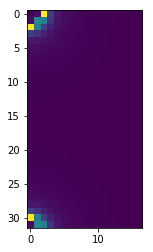

In [109]:
imshow(theo_ps(array([[0.5,0.9]]))[0])

/global/u2/a/avirukt/proj/power_spectrum.py:159: RuntimeWarning: invalid value encountered in true_divide
  field /= k2
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


array([0.28337967, 0.80222836])

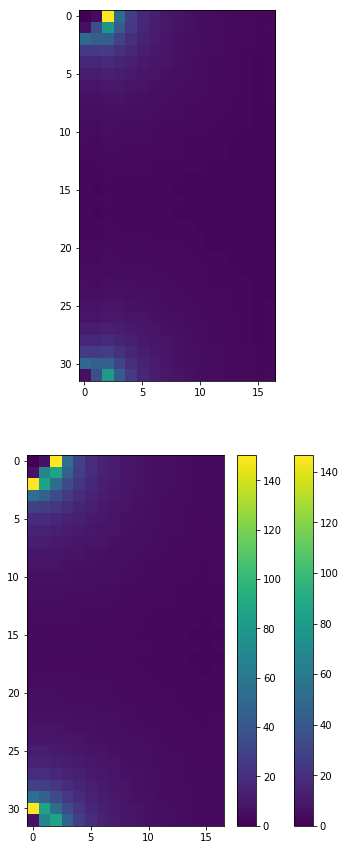

In [275]:
p = rand(2)
y = abs(fft.rfftn(fast_gaussian(spectral_index(p[0]*ones(10000)), fnl=10.**(6*p[1]-3)), axes=(1,2)))**2/1024
x = mean(y,axis=0)
f,ax = subplots(2,1,figsize=(6,15))
colorbar(ax[0].imshow(x))
colorbar(ax[1].imshow(theo_ps(p.reshape((1,2)))[0]))
p

/global/u2/a/avirukt/proj/power_spectrum.py:159: RuntimeWarning: invalid value encountered in true_divide
  field /= k2


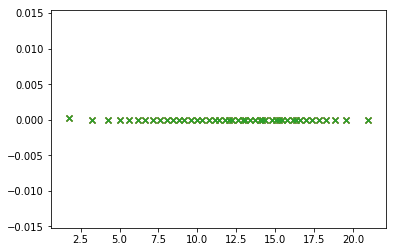

In [112]:
fnl = zeros(3)
x = fast_gaussian(spectral_index(0.9*ones(len(fnl))), fnl=fnl, constant_phase=True)
for y in x:
    k,Pk = dynamic_ps(y,count=20)[:2]
    scatter(k,Pk,marker="x")

In [255]:
nsims_train = 10**5
nsims_test = 10**3

p_train = rand(nsims_train,2)
p_test = rand(nsims_test, 2)
#p_test[:,1] = 0.6
#p_test[:,1]= rand(nsims_test)*0.3+0.7

sims = lambda p: standardise_ps(fast_gaussian(spectral_index(p[:,0]), fnl=10.**(6*p[:,1]-3)), lambda x: 1, ps=True, originals=theo_ps(p).reshape((len(p),-1)))

In [256]:
x_train = sims(p_train)
x_test = sims(p_test)

/global/u2/a/avirukt/proj/power_spectrum.py:159: RuntimeWarning: invalid value encountered in true_divide
  field /= k2
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/global/u2/a/avirukt/proj/power_spectrum.py:317: RuntimeWarning: divide by zero encountered in true_divide
  x *= sqrt(new/originals)
/global/u2/a/avirukt/proj/power_spectrum.py:317: RuntimeWarning: invalid value encountered in multiply
  x *= sqrt(new/originals)
/global/u2/a/avirukt/proj/power_spectrum.py:159: RuntimeWarning: invalid value encountered in true_divide
  field /= k2
/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/ipykernel

In [ ]:
model = LFI(["field"], ["power spectral index","$f_{NL}$"], model_dir='/global/cscratch1/sd/avirukt/models/fnlts1')
batch_size=128
model.train(training_fn_generator(x_train, p_train, batch_size=batch_size), max_steps=40*nsims_train//batch_size)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/fnlts1/model.ckpt-31250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


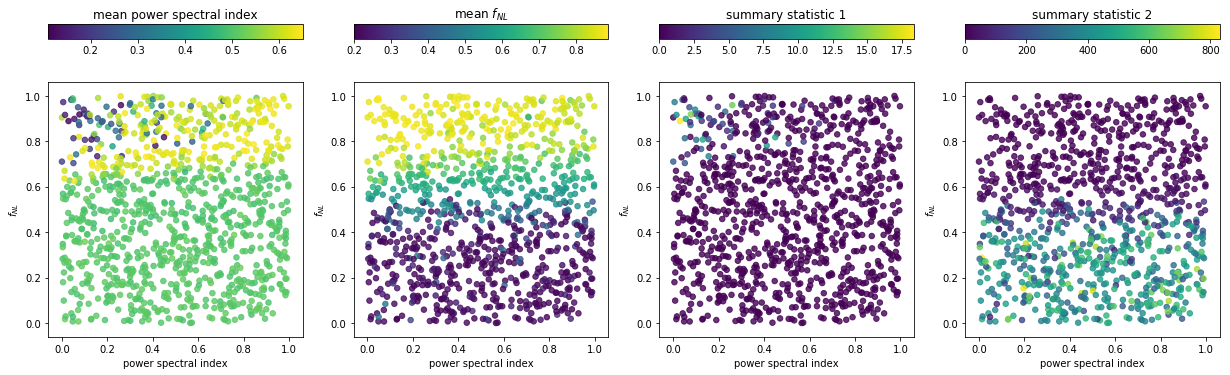

In [259]:
model.plot_2d(x_test, p_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/fnlts1/model.ckpt-31250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


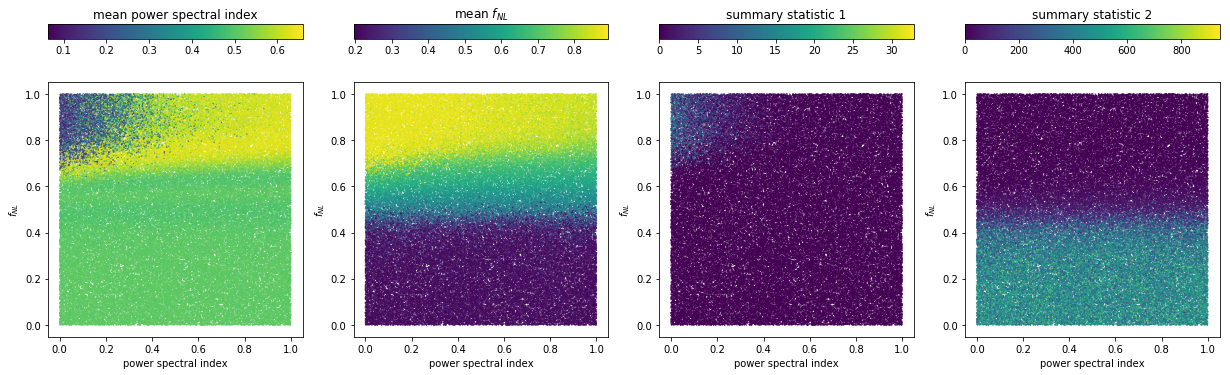

In [260]:
model.plot_2d(x_train, p_train)

In [276]:
post = model.plot_posteriors(x_test, p_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /global/cscratch1/sd/avirukt/models/fnlts1/model.ckpt-31250
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


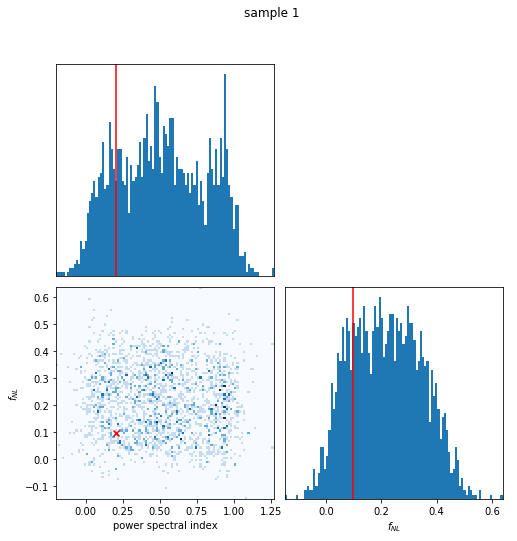

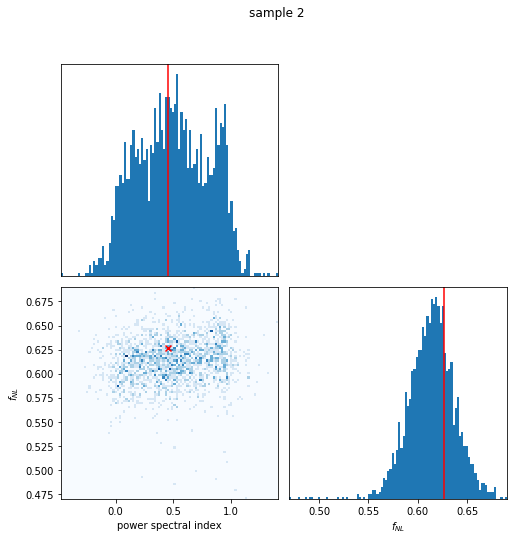

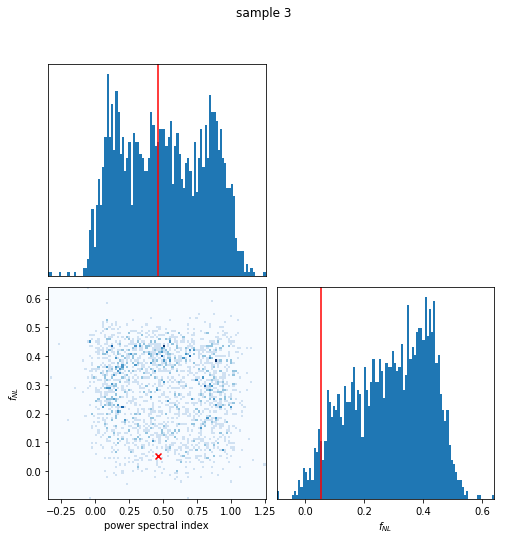

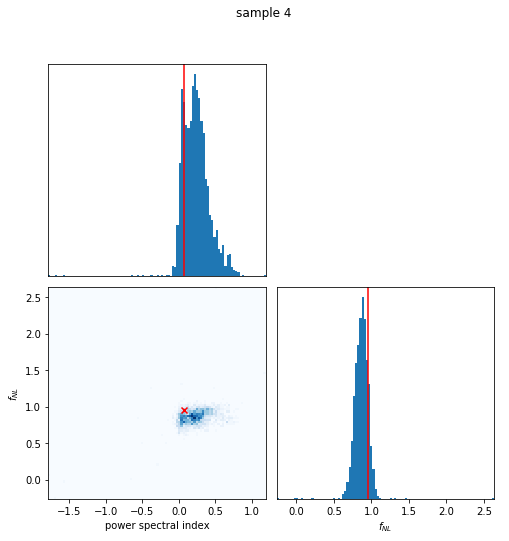

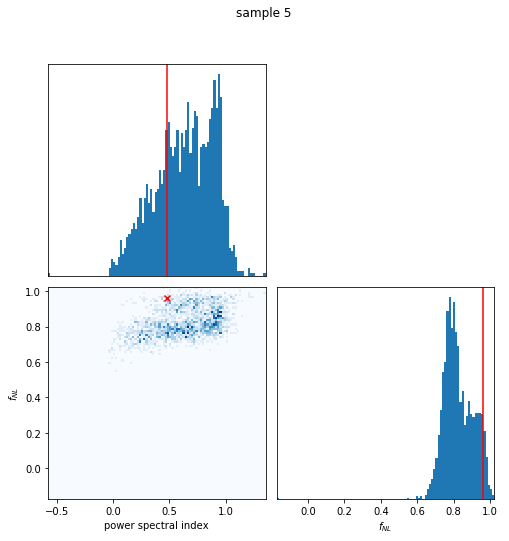

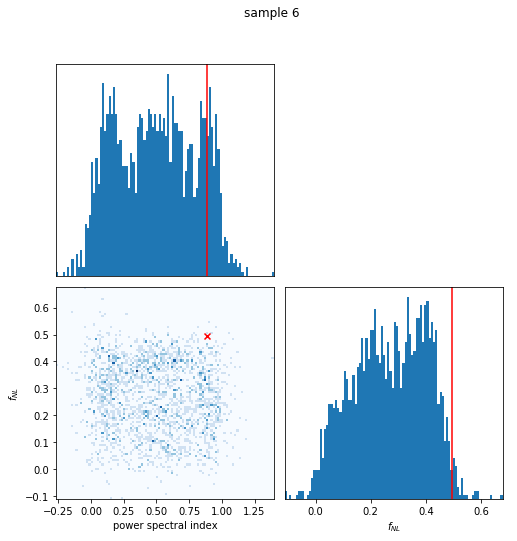

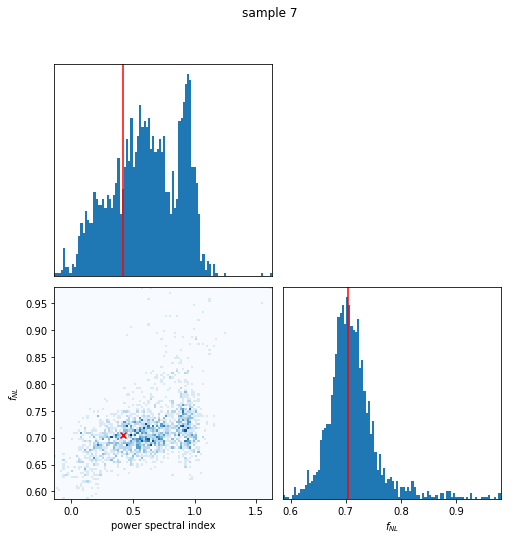

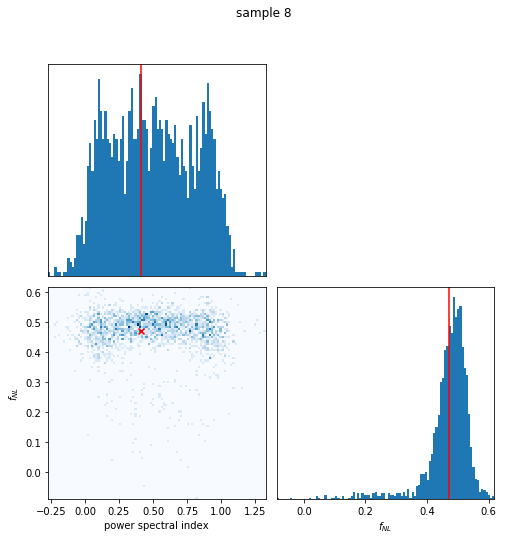

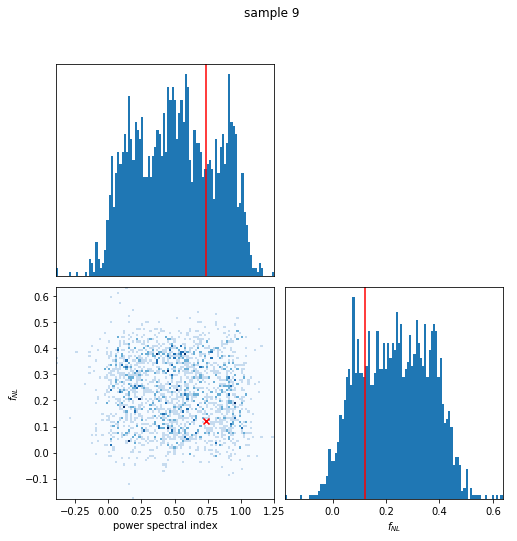

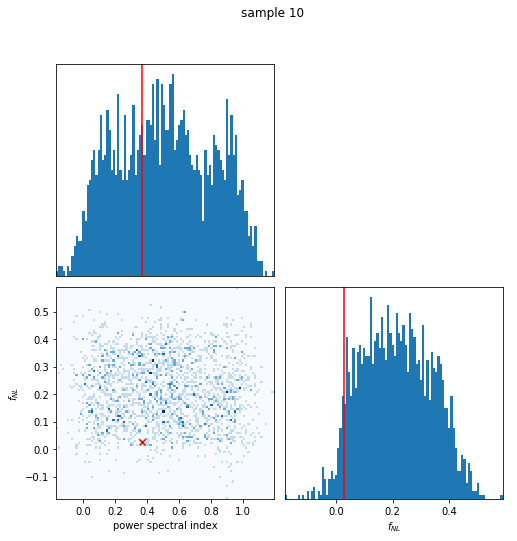

In [277]:
for i in range(10):
    next(post)

In [254]:
means = []
for i in range(nsims_test):
    means.append(mean(dynamic_ps(x_test[i])[1]))
means = 1024*array(means)

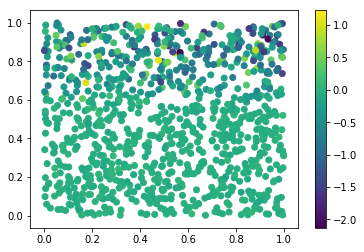

In [241]:
scatter(*p_test.T, c=log(means))
colorbar()

Text(0, 0.5, "mean 'whitened' PS")

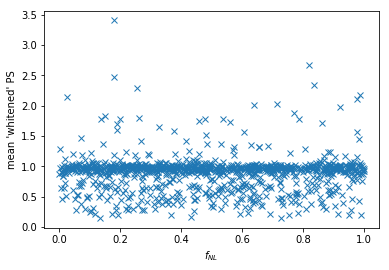

In [257]:
plot(p_test[:,1],means, ls="", marker="x")
#yscale("log")
xlabel("$f_{NL}$")
ylabel("mean 'whitened' PS")

In [250]:
binned_statistic(p_test[:,1],means,"mean")[0]

/global/homes/a/avirukt/.conda/envs/nbk/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


array([0.97167657, 0.9664898 , 0.97067564, 0.96883391, 0.96650237,
       0.95349609, 0.86582126, 0.72738464, 0.83526003, 0.73533954])

In [219]:
j=30

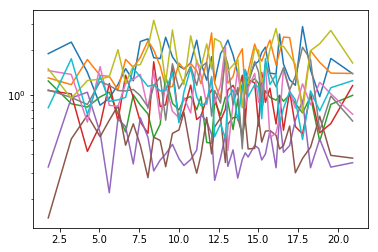

In [246]:
for i in range(10):
    j += 1
    plot(*dynamic_ps(32*x_test[j])[:2],label=p_test[j])
#legend()
yscale("log")